# Summary of the Model
- Population Size = 50
- Max Generations = 30
- Using Binary Encoding to represent chromosome solution
- Each Chromosome defined as = ( alpha | Activation Func | ctr(HL1 Neurons) | ctr(HL2 Neurons) )
- Total Genes = 20
- Training on Diabetes Dataset With Train/Val/Test Split : 0.6/0.1/0.3 
- Following are the parameter details

    | Parameter        	    |    Values/Range                       	    | No.of Bits Required |
    |-------------------    |-----------------------------------------------|---------------------|
    | Alpha            	    |     [ 0.0039 - 0.9961 ]               	    |          08         |
    | Activation Func  	    |    { Sigmoid - 0, Tanh - 1, ReLU - 2} 	    |          02         |
    | ctr(HL1 Neurons) 	    |    {5...31}                           	    |          05         |
    | ctr(HL2 Neurons) 	    |    {0...31}                           	    |          05         |


# Defining Parameter Values and Constraints

In [ ]:
# GA Parameter Contraints
alpha_min=0.0039
alpha_max=0.9961
alpha_bits=8

AF_min=0
AF_max=2
AF_bits=2
AF = ['sigmoid','tanh','relu']

HL1_ctr_min=5
HL1_ctr_max=31
HL1_ctr_bits=5

HL2_ctr_min=0
HL2_ctr_max=31
HL2_ctr_bits=5

# GA Parameters
pop_size = 30    # total Chromosomes/ possible solution in each generation
tot_genes = alpha_bits + AF_bits + HL1_ctr_bits + HL2_ctr_bits      # total genes/params in each chromosome
elitepop_ctr = int(0.1*pop_size)
if pop_size - elitepop_ctr %2!=0:
    elitepop_ctr+=1
maxGen=30
ProbOfCross=0.8
ProbOfMut=0.1

# Dataset Parameters
train_split=0.6
val_split=0.1
test_split=0.3

featureCtr=8

# NN weight initialization range
wlow = -1.0
whigh = 1.0

#NN Train Params
Epochs = 30
batch_size = 512
verbose = 0


# Importing Libraries

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm as tqdm
from statistics import mean
import tensorflow_addons as tfa
import time
from ttictoc import tic,toc

tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(1)


# Loading Dataset and Splitting

In [3]:
df = pandas.read_csv("diabetes.csv",header=0,index_col=None)
df = df.sample(frac=1).reset_index(drop=True)
m=df.shape[0]

train, val, test = np.split(df,[int(train_split*m), int((train_split+val_split)*m)])

X_train = train[train.columns[0:8]]
Y_train = train[train.columns[8]]

X_val = val[val.columns[0:8]]
Y_val = val[val.columns[8]]

X_test = test[test.columns[0:8]]
Y_test = test[test.columns[8]]


# Preprocessing Data

In [4]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


# Declaring Helper Functions

In [5]:

def binToFrac(binStr):
    binVal=0.0
    for i in range(len(binStr)):
        binVal+=int(binStr[i])*(2**(-(i+1)))
    return binVal

def binToDec(binStr):
    return int(binStr,2)

def generateBinStr(bits):
    randList=np.random.rand(bits)
    BinList=(randList>0.5).astype('int').astype('str')
    return "".join(BinList)

def is_valid(val,param):
    if param == "alpha" and val >= alpha_min and val <= alpha_max:
        return True
    elif param == "AF" and val >= AF_min and val <= AF_max:
        return True
    elif param == "HL1_ctr" and val >= HL1_ctr_min and val <= HL1_ctr_max:
        return True
    elif param == "HL2_ctr" and val >= HL2_ctr_min and val <= HL2_ctr_max:
        return True
    return False

def init_alpha():
    while True:            
        alpha_bin=generateBinStr(alpha_bits)
        alpha_val=binToFrac(alpha_bin)
        if is_valid(alpha_val,"alpha"):
            break
    return alpha_bin,alpha_val
    
def init_AF():
    while True:            
        AF_bin=generateBinStr(AF_bits)
        AF_val=binToDec(AF_bin)
        if is_valid(AF_val,"AF"):
            break
    return AF_bin,AF_val

def init_HL1_ctr():    
    while True:            
        HL1_ctr_bin=generateBinStr(HL1_ctr_bits)
        HL1_ctr_val=binToDec(HL1_ctr_bin)
        if is_valid(HL1_ctr_val,"HL1_ctr"):
            break
    return HL1_ctr_bin,HL1_ctr_val

def init_HL2_ctr():
    while True:            
        HL2_ctr_bin=generateBinStr(HL2_ctr_bits)
        HL2_ctr_val=binToDec(HL2_ctr_bin)
        if is_valid(HL2_ctr_val,"HL2_ctr"):
            break
    return HL2_ctr_bin,HL2_ctr_val

def get_alpha(chromo_bin):
    alpha_bin=chromo_bin[0:alpha_bits]
    alpha_val=binToFrac(alpha_bin)
    if is_valid(alpha_val,"alpha"):
        return alpha_bin,alpha_val        
    return init_alpha()

def get_AF(chromo_bin):
    AF_bin=chromo_bin[(alpha_bits):(alpha_bits+AF_bits)]
    AF_val=binToDec(AF_bin)
    if is_valid(AF_val,"AF"):
        return AF_bin,AF_val
    return init_AF()
    

def get_HL1_ctr(chromo_bin):    
    HL1_ctr_bin=chromo_bin[(alpha_bits+AF_bits):(alpha_bits+AF_bits+HL1_ctr_bits)]
    HL1_ctr_val=binToDec(HL1_ctr_bin)
    if is_valid(HL1_ctr_val,"HL1_ctr"):
        return HL1_ctr_bin,HL1_ctr_val
    return init_HL1_ctr()

def get_HL2_ctr(chromo_bin):
    HL2_ctr_bin=chromo_bin[(alpha_bits+AF_bits+HL1_ctr_bits):]
    HL2_ctr_val=binToDec(HL2_ctr_bin)
    if is_valid(HL2_ctr_val,"HL2_ctr"):
        return HL2_ctr_bin,HL2_ctr_val  
    return init_HL2_ctr()


# Defining Chromosome Class

In [6]:
# Encapsulating all Chromosome Initialization and defining
# Trains the model created by the created parameter value set 
# And logs the metrics and stores the best model as the object Attribute
class chromosome:

    def init_chromosome(self):
        self.alpha_bin,self.alpha_val=init_alpha()
        self.AF_bin,self.AF_val=init_AF()
        self.HL1_ctr_bin,self.HL1_ctr_val=init_HL1_ctr()
        self.HL2_ctr_bin,self.HL2_ctr_val=init_HL2_ctr()
        
        self.chromo_bin=self.alpha_bin+self.AF_bin+self.HL1_ctr_bin+self.HL2_ctr_bin
        self.tot_genes=4
        self.AF_name=AF[self.AF_val]

    def set_chromosome(self,chromo_bin_str):
        self.alpha_bin,self.alpha_val=get_alpha(chromo_bin_str)
        self.AF_bin,self.AF_val=get_AF(chromo_bin_str)
        self.HL1_ctr_bin,self.HL1_ctr_val=get_HL1_ctr(chromo_bin_str)
        self.HL2_ctr_bin,self.HL2_ctr_val=get_HL2_ctr(chromo_bin_str)
        
        self.chromo_bin=self.alpha_bin+self.AF_bin+self.HL1_ctr_bin+self.HL2_ctr_bin
        self.tot_genes=4
        self.AF_name=AF[self.AF_val]

    def get_model_params(self):
        return self.alpha_val,self.AF_name,self.HL1_ctr_val,self.HL2_ctr_val

    def create_model(self):
        
        opt = tf.keras.optimizers.SGD(learning_rate=self.alpha_val)
        initializer = tf.keras.initializers.RandomUniform(minval=wlow, maxval=whigh)
        
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(self.HL1_ctr_val,input_shape=(featureCtr,),activation=self.AF_name,kernel_initializer=initializer))
        if(self.HL2_ctr_val>0):
            model.add(tf.keras.layers.Dense(self.HL2_ctr_val,activation=self.AF_name,kernel_initializer=initializer))
        model.add(tf.keras.layers.Dense(1,activation='sigmoid',kernel_initializer=initializer))        
        
        model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])        
        self.model=model
        return
    
    def train_model(self):   
        es=EarlyStopping(monitor='val_loss', patience=5, verbose=verbose, mode='min',restore_best_weights=True)
        #tqdm_cb = tfa.callbacks.TQDMProgressBar()
        self.model.fit(x=X_train,y=Y_train, batch_size=batch_size, epochs=Epochs,validation_data=(X_val,Y_val),validation_batch_size=batch_size,callbacks=[es],verbose=verbose)
        
        best_model=self.model
        Train_History=best_model.evaluate(x=X_train,y=Y_train,batch_size=batch_size,verbose=verbose)
        Val_History=best_model.evaluate(x=X_val,y=Y_val,batch_size=batch_size,verbose=verbose)
        Test_History=best_model.evaluate(x=X_test,y=Y_test,batch_size=batch_size,verbose=verbose)

        self.metrics={
            'train_loss': round(Train_History[0],4),
            'train_accuracy': round(Train_History[1],4),
            'val_loss' : round(Val_History[0],4),
            'val_accuracy' : round(Val_History[1],4),
            'test_loss' : round(Test_History[0],4),
            'test_accuracy' : round(Test_History[1],4)
        }
        return

    def __init__(self,chromo_bin_str=None):
        if chromo_bin_str==None:
            self.init_chromosome()
        else:
            self.set_chromosome(chromo_bin_str)
        self.create_model()
        self.train_model()


# Test Run to create chromosome Object

In [ ]:
tic()
chromo=chromosome()
toc()
print(chromo.get_model_params())
chromo.metrics


# Crossover and Mutation Functions

In [7]:
def onePointCrossover(p1,p2):
    #p1 p2 being bit strings
    point=np.random.randint(1,tot_genes)
    
    off1 = p1[0:point] + p2[point:]
    off2 = p2[0:point] + p1[point:]
    
    off1=chromosome(off1)
    off2=chromosome(off2)
    
    return off1,off2

def onePointMutation(chromo_bin):   
    mutList=(np.random.rand(tot_genes) < 0.5 )
    binList=(np.random.rand(tot_genes) > 0.5 ).astype('int').astype('str')
    
    binStr=""    
    for i in range(tot_genes):
        if mutList[i]:
            binStr+=binList[i]
        else:
            binStr+=chromo_bin[i]
    return chromosome(binStr)


# Generation Class 

In [43]:
# Encapsulating all Generation Operations to create Next Gen
# Sets initial Gen, and declares metric storing variabls
# Logs generation Test loss and Accuracy and Calculates fitness
# Gets the best Elite population to forward to the next Gen
# The remaining Gen is selected by choosing parents by random Roulette selection method 
# Applying Crossover and Mutation as per Probability of Crossover and Mutation to produce offsprings
class Generation:

    def __init__(self,curGen):
        self.curGen=curGen
        self.nextGen=[None]*pop_size
        self.gen_loss=np.empty(pop_size)
        self.gen_accuracy=np.empty(pop_size)
        self.gen_fitness=np.empty(pop_size)
        self.LossLines = {'max':[],'min':[],'mean':[]}
        self.FitnessLines = {'max':[],'min':[],'mean':[]}
        self.AccuracyLines = {'max':[],'min':[],'mean':[]}

    def getCurGen(self):
        return self.curGen

    def printCurGen(self):
        print(self.curGen)

    def get_Gen_Metrics(self):
        self.gen_loss = np.array([self.curGen[x].metrics['test_loss'] for x in range(pop_size)])
        self.gen_accuracy = np.array([self.curGen[x].metrics['test_accuracy'] for x in range(pop_size)])
        
    def get_elite_pop(self):
        elitePop_index = np.argsort(self.gen_loss)[0:elitepop_ctr]
        elitePop = np.array(self.curGen)[elitePop_index.astype('int')]
        return elitePop

    def get_fitness(self):
        invertedLosses = 1/self.gen_loss
        sum = np.sum(invertedLosses)
        self.gen_fitness = (invertedLosses/sum)*100 
        self.cum_gen_fitness = np.cumsum(self.gen_fitness)

    def roulette_wheel(self):
        
        val = np.random.rand()*100 
        p1=np.digitize(val,self.cum_gen_fitness,right=True)

        while True:
            val = np.random.rand()*100 
            p2=np.digitize(val,self.cum_gen_fitness,right=True)

            if p2!=p1:
                break

        return (p1,p2)

    def logMetrics(self):
        self.LossLines['max'].append(max(self.gen_loss))
        self.LossLines['min'].append(min(self.gen_loss))
        self.LossLines['mean'].append(mean(self.gen_loss))

        self.FitnessLines['max'].append(max(self.gen_fitness))
        self.FitnessLines['min'].append(min(self.gen_fitness))
        self.FitnessLines['mean'].append(mean(self.gen_fitness))
        
        self.AccuracyLines['max'].append(max(self.gen_accuracy)*100)
        self.AccuracyLines['min'].append(min(self.gen_accuracy)*100)
        self.AccuracyLines['mean'].append(mean(self.gen_accuracy)*100)
        
    def createNextGen(self):
        self.get_Gen_Metrics()
        self.get_fitness()
        self.logMetrics()

        nextGen=[None]*pop_size
        nextGen[0:elitepop_ctr] = self.get_elite_pop()
        
        mutFlag1=(np.random.rand(pop_size) < ProbOfMut)
        mutFlag2=(np.random.rand(pop_size) < ProbOfMut)
        crossFlag=(np.random.rand(pop_size) < ProbOfCross)

        i=elitepop_ctr
        while i<pop_size:
            p1,p2 = self.roulette_wheel()
            p1_chromo=self.curGen[p1]
            p2_chromo=self.curGen[p2]    
            
            nextGen[i]=p1_chromo
            nextGen[i+1]=p2_chromo   
            
            if crossFlag[i]:            
                off1,off2 = onePointCrossover(p1_chromo.chromo_bin,p2_chromo.chromo_bin)
                nextGen[i]=off1
                nextGen[i+1]=off2
            if mutFlag1[i]: 
                nextGen[i]=onePointMutation(nextGen[i].chromo_bin)
            if mutFlag2[i]: 
                nextGen[i+1]=onePointMutation(nextGen[i+1].chromo_bin)
            
            #print("%d Done!"%(i+1))
            i+=2
            
        self.curGen = nextGen


# Generating Initial Population

In [ ]:
curGen=[None]*pop_size

for i in tqdm(range(pop_size),"Chromosomes generated"):
    chromo=chromosome()
    curGen[i]=chromo

# Creating Further Generations upto MaxGen

In [44]:

Gen=Generation(curGen)
for i in tqdm(range(30),"Generations Completed"):
    print("\n  Creating Next Gen %d:\n"%(i+1))
    Gen.createNextGen()




  Creating Next Gen 1:


	 Elite  Done.
5 Done!
7 Done!
9 Done!
11 Done!
13 Done!
15 Done!
17 Done!
19 Done!
21 Done!
23 Done!
25 Done!
27 Done!
29 Done!

	 Gen  Done.

  Creating Next Gen 2:


	 Elite  Done.
5 Done!
7 Done!
9 Done!
11 Done!
13 Done!
15 Done!
17 Done!
19 Done!
21 Done!
23 Done!
25 Done!
27 Done!
29 Done!

	 Gen  Done.

  Creating Next Gen 3:


	 Elite  Done.
5 Done!
7 Done!
9 Done!
11 Done!
13 Done!
15 Done!
17 Done!
19 Done!
21 Done!
23 Done!
25 Done!
27 Done!
29 Done!

	 Gen  Done.

  Creating Next Gen 4:


	 Elite  Done.
5 Done!
7 Done!
9 Done!
11 Done!
13 Done!
15 Done!
17 Done!
19 Done!
21 Done!
23 Done!
25 Done!
27 Done!
29 Done!

	 Gen  Done.

  Creating Next Gen 5:


	 Elite  Done.
5 Done!
7 Done!
9 Done!
11 Done!
13 Done!
15 Done!
17 Done!
19 Done!
21 Done!
23 Done!
25 Done!
27 Done!
29 Done!

	 Gen  Done.

  Creating Next Gen 6:


	 Elite  Done.
5 Done!
7 Done!
9 Done!
11 Done!
13 Done!
15 Done!
17 Done!
19 Done!
21 Done!
23 Done!
25 Done!
27 Done!
29 Done!


# Defining Metrics Plotting Function

In [55]:
def plot_Metrics(i,metricDict,metricName,maxGen,xStep,yStep):
    
    plt.figure(i)
    
    xMaxVal=maxGen+1
    yMaxVal=max(metricDict['max'])+1
    
    plt.xlim(0,xMaxVal)
    plt.ylim(0,yMaxVal)
    
    plt.xticks(np.arange(0,xMaxVal,xStep))
    plt.yticks(np.arange(0,yMaxVal,yStep))
    
    plt.xlabel("Generation No.")
    plt.ylabel(metricName)
    plt.title("NN %s vs Generation"%(metricName))
    
    maxColor="red"
    minColor="green"
    meanColor="blue"
    
    m1,=plt.plot(metricDict['max'],color=maxColor)
    m2,=plt.plot(metricDict['min'],color=minColor)
    m3,=plt.plot(metricDict['mean'],color=meanColor)
    
    plt.legend([m1,m2,m3],["Max "+metricName,"Min "+metricName,"Average "+metricName],loc="upper right")
    
    return

# Plot Test Loss, Accuracy, Fitness Accross Generations

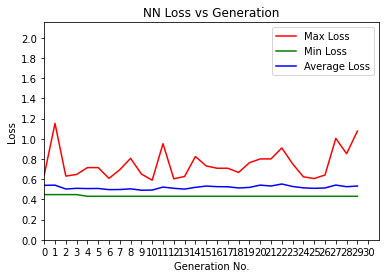

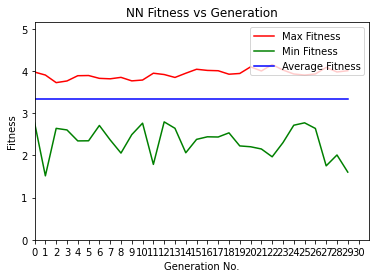

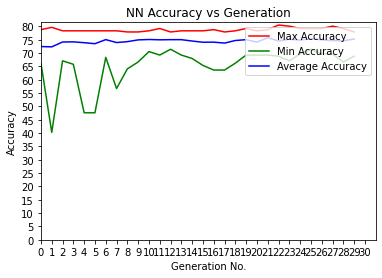

In [57]:
xStep=1
plot_Metrics(0,Gen.LossLines,"Loss",maxGen,xStep,0.2)
plot_Metrics(1,Gen.FitnessLines,"Fitness",maxGen,xStep,1)
plot_Metrics(2,Gen.AccuracyLines,"Accuracy",maxGen,xStep,5)

plt.show()

# Current Best Gen Solution Parameters

In [60]:
print("Gen Chromo Params")
for i in range(pop_size):
    print("\n  %d : "%(i+1),Gen.curGen[i].get_model_params())

Gen Chromo Params

  1 :  (0.390625, &#39;relu&#39;, 21, 30)

  2 :  (0.390625, &#39;relu&#39;, 21, 30)

  3 :  (0.390625, &#39;relu&#39;, 21, 30)

  4 :  (0.390625, &#39;relu&#39;, 21, 30)

  5 :  (0.390625, &#39;relu&#39;, 21, 28)

  6 :  (0.171875, &#39;relu&#39;, 29, 30)

  7 :  (0.39453125, &#39;relu&#39;, 22, 9)

  8 :  (0.3671875, &#39;relu&#39;, 21, 26)

  9 :  (0.390625, &#39;sigmoid&#39;, 21, 28)

  10 :  (0.171875, &#39;relu&#39;, 29, 28)

  11 :  (0.390625, &#39;relu&#39;, 21, 30)

  12 :  (0.390625, &#39;relu&#39;, 21, 30)

  13 :  (0.390625, &#39;relu&#39;, 21, 30)

  14 :  (0.265625, &#39;relu&#39;, 25, 30)

  15 :  (0.39453125, &#39;relu&#39;, 19, 30)

  16 :  (0.390625, &#39;relu&#39;, 21, 30)

  17 :  (0.390625, &#39;relu&#39;, 21, 30)

  18 :  (0.390625, &#39;relu&#39;, 21, 30)

  19 :  (0.64453125, &#39;relu&#39;, 13, 30)

  20 :  (0.390625, &#39;relu&#39;, 21, 30)

  21 :  (0.3671875, &#39;relu&#39;, 21, 30)

  22 :  (0.39453125, &#39;relu&#39;, 17, 31)

  23 :  (0

# Extracting Best Solution from Current Best Gen

In [62]:
# Last Run Best Model Params 
# 1 :  (0.390625, 'relu', 21, 30)

print(Gen.curGen[0].get_model_params())
Gen.curGen[0].metrics


{&#39;train_loss&#39;: 0.4218,
 &#39;train_accuracy&#39;: 0.7935,
 &#39;val_loss&#39;: 0.7926,
 &#39;val_accuracy&#39;: 0.6364,
 &#39;test_loss&#39;: 0.4306,
 &#39;test_accuracy&#39;: 0.7792}

In [11]:
# Last Run Best Model Params 
# 1 :  (0.390625, 'relu', 21, 30)

print("\n  Best Solution Model Params :  (0.390625, 'relu', 21, 30)")
print("\n  Best Solution Model Metrics : ")
print("\t{\'train_loss\': 0.4218,\n\
 \t\'train_accuracy\': 0.7935,\n\
 \t\'val_loss\': 0.7926,\n\
 \t\'val_accuracy\': 0.6364,\n\
 \t\'test_loss\': 0.4306,\n\
 \t\'test_accuracy\': 0.7792}\n")


  Best Solution Model Params :  (0.390625, &#39;relu&#39;, 21, 30)

  Best Solution Model Metrics : 
	{&#39;train_loss&#39;: 0.4218,
 	&#39;train_accuracy&#39;: 0.7935,
 	&#39;val_loss&#39;: 0.7926,
 	&#39;val_accuracy&#39;: 0.6364,
 	&#39;test_loss&#39;: 0.4306,
 	&#39;test_accuracy&#39;: 0.7792}



# Saving the corresponding Best Trained Model

In [66]:
best_model = Gen.curGen[0].model
tf.keras.models.save_model(
    best_model, filepath='./checkpoints/', overwrite=True, include_optimizer=True,
)

# Validating Best Model on Dataset Splits

In [67]:
verbose=1
Train_History=best_model.evaluate(x=X_train,y=Y_train,batch_size=batch_size,verbose=verbose)
Val_History=best_model.evaluate(x=X_val,y=Y_val,batch_size=batch_size,verbose=verbose)
Test_History=best_model.evaluate(x=X_test,y=Y_test,batch_size=batch_size,verbose=verbose)

1/1 [==============================] - 0s 3ms/step - loss: 0.4306 - accuracy: 0.7792
